# Finding Similar Songs on Spotify

In this tutorial I will demonstrate how to apply machine learning to search for similar songs on Spotify.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

Install the following dependencies to run this tutorial:

In [2]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

**Spotipy**

Spotipy is a thin client library for the Spotify Web API.

https://github.com/plamere/spotipy

In [3]:
import spotipy
import spotipy.util as util

TODO: describe how to get client credentials

In [4]:
os.environ["SPOTIPY_CLIENT_ID"]     = "8a7fffc37b6c44e6b7bc344c3295034c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "f19dd914ba58408c9407dd6479b23812"

If you get the following message:

    User authentication requires interaction with your
    web browser. Once you enter your credentials and
    give authorization, you will be redirected to
    a url.  Paste that url you were directed to to
    complete the authorization.

    Opened https://accounts.spotify.com/authorize?scope=playlist-modify-public&redirect_uri=ht...
    

You need to authenticate your browser session. Follow the link and log in to Spotify. After login, you will be redirected to http://localhost/?code=... Copy the entire URL and paste it to the prompted textbox.

In [58]:
token = util.prompt_for_user_token("slychief", 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

# Loading Data

Before we can train our models we first have to get some data.

## Download Echonest Features from Spotify

We use spotipy to access the Spotify API and to download metadata and audio features of Spotify tracks. The following list provides a selection of Spotify playlists of various music genres.

In [6]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

### Get Playlist meta-data

Instead of writing one big loop to download the data, I decided to split it into separate more comprehensible steps.

The Spotify API does not return infinite elements, but requires batch processing. The largest batch size is 100 items such as tracks, artists or albums. As a first step we get relevant meta-data for the supplied playlists. Especially the *num_track* property is convenient for the further processing.

In [59]:
for playlist in playlists:
    
    # get user and playlist_id from uri
    (_,_,user,_,playlist_id) = playlist["uri"].split(":")
    
    # retrieve playlist metadat from Spotify
    playlist_metadata = sp.user_playlist(user        = user,
                                         playlist_id = playlist_id)
    
    # extract relevant information
    playlist["user"]        = user
    playlist["playlist_id"] = playlist_id
    playlist["num_tracks"]  = playlist_metadata["tracks"]["total"]
    
    # initialize fields for further processing
    playlist["track_ids"]   = []

**Size of our dataset**

Now we can already estimate the approximate size of our data-set. The set might contain duplicate tracks from overlapping playlists. Those are removed later on.

In [8]:
num_tracks_total = np.sum([playlist["num_tracks"] for playlist in playlists])
num_tracks_total

966

### Get track-ids of all playlist entries

To download meta- and feature-data for tracks, we need to fetch the playlist entries.

In [60]:
# max Spotify batch size
batch_size = 100

# retrieve tracks for each playlist
for playlist in playlists:
    
    # batch processing
    for offset in np.arange(0, playlist["num_tracks"], batch_size):
               
        limit = np.min([batch_size, playlist["num_tracks"] - offset])
        
        playlist_entries = sp.user_playlist_tracks(user        = playlist["user"],
                                                   playlist_id = playlist["playlist_id"], 
                                                   limit       = limit, 
                                                   offset      = offset,
                                                   fields      = ["items"])
        
        playlist["track_ids"].extend([entry["track"]["id"] for entry in playlist_entries["items"]])

### Fetch data and features from Spotify

### Caching with joblib

We will use caching to locally store retrieved data. This is on the one hand a requirement of the API and on the other it speeds up processing when we reload the notebook. *joblib* is a convenient library which simplifies caching.

*Update the cachedir to an appropriate path in the following cell*

In [10]:
from joblib import Memory

memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

The following method retrieves meta-data, sequential features such as *MFCCs* and *Chroma*, and track-level features such as *Danceability*. The *@memory.cache* annotation tells *joblib* to persist all return values for the supplied parameters.

In [11]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

**Retrieving data for all tracks**

The following loop downloads meta- and feature-data for all tracks. The *processed_track_ids* list is used to avoid duplicated entries. Be aware that downloading a lot of tracks could take some time. Processing 1.000 tracks may take about 15 to 30 minutes.

In [56]:
pbar = progressbar.ProgressBar(max_value=num_tracks_total)
pbar.start()

raw_track_data      = []
processed_track_ids = []

for playlist in playlists:
    
    for track_id in playlist["track_ids"]:
    
        try:
            # avoid duplicates in the data-set
            if track_id not in processed_track_ids:
                
                # retrieve data from Spotify
                spotify_data = get_spotify_data(track_id)
            
                raw_track_data.append([playlist["name"], spotify_data])
                processed_track_ids.append(track_id)
                
        except Exception as e:
            print e
        
        pbar.update(len(raw_track_data))

 62% (604 of 966) |#################################################################################################################                                                                     | Elapsed Time: 0:00:25 ETA: 0:00:14

http status: 401, code:-1 - https://api.spotify.com/v1/tracks/5Nb6txEq65b9UfeplVF2a8:
 The access token expired


 97% (938 of 966) |################################################################################################################################################################################      | Elapsed Time: 0:00:40 ETA: 0:00:01

# Aggregate data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

## Aggregate Meta-data

First we aggregate the meta-data. All relevant information is stored in a dataframe.

In [ ]:
metadata = []

for playlist_name, spotify_data in raw_track_data:
    
    track_metadata, album_metadata, artist_metadata, _, _ = spotify_data
    
    # get year of album release
    release_date = album_metadata["release_date"]
    
    if album_metadata["release_date_precision"] != "year":
        release_date = release_date.split("-")[0]
    
    # assamble metadata
    metadata.append([track_metadata["id"],
                     artist_metadata["name"], 
                     track_metadata["name"], 
                     album_metadata["name"],
                     album_metadata["label"],
                     track_metadata["duration_ms"],
                     track_metadata["popularity"],
                     release_date,
                     artist_metadata["genres"], 
                     playlist_name])
    
metadata = pd.DataFrame(metadata, columns=["track_id", "artist_name", "title", "album_name", "label", 
                                           "duration", "popularity",  "year",  "genres", "playlist"])

Here an example of the aggregated meta-data:

In [62]:
metadata.sort_values("popularity", ascending=False).head()

,track_id,artist_name,title,album_name,label,duration,popularity,year,genres,playlist
794,2eMwDehkIC1j68U6FA3Eiq,Lil Uzi Vert,XO TOUR Llif3,XO TOUR Llif3,Generation Now/Atlantic,182706,98,2017,"[dwn trap, pop rap, rap, trap music]",hiphop
248,4q8PHoRsPUB52LFylX8Ulz,Axwell /\ Ingrosso,More Than You Know,More Than You Know,Digital Distribution Trinidad and Tobago,203000,96,2017,"[big room, edm, electro house, pop, tropical h...",electropop
835,3HVr6jTVwBHBa2flM0eURR,Macklemore,Glorious (feat. Skylar Grey),Glorious (feat. Skylar Grey),Bendo LLC,220454,96,2017,[pop rap],hiphop
100,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,÷ (Deluxe),Atlantic Records UK,233712,96,2017,[pop],softpop
801,5eqK0tbzUPo2SoeZsov04s,21 Savage,Bank Account,Issa Album,"Slaughter Gang, LLC/Epic Records",220306,95,2017,"[dwn trap, pop rap, rap, trap music]",hiphop


## Aggregate Features



In [14]:
def get_random_segment(seq_data, track_data, len_segment, metadata):

    # sequential data
    mfcc              = np.array([s["timbre"]            for s in seq_data["segments"]])
    chroma            = np.array([s["pitches"]           for s in seq_data["segments"]])
    loudness_max      = np.array([s["loudness_max"]      for s in seq_data["segments"]]).reshape((mfcc.shape[0],1))
    loudness_start    = np.array([s["loudness_start"]    for s in seq_data["segments"]]).reshape((mfcc.shape[0],1))
    loudness_max_time = np.array([s["loudness_max_time"] for s in seq_data["segments"]]).reshape((mfcc.shape[0],1))
    duration          = np.array([s["duration"]          for s in seq_data["segments"]]).reshape((mfcc.shape[0],1))
    confidence        = np.array([s["confidence"]        for s in seq_data["segments"]]).reshape((mfcc.shape[0],1))
    
    # concatenate
    seq_features = np.concatenate([confidence, duration, loudness_max, loudness_max_time, loudness_start, chroma, mfcc], axis=1)
    
    # get a random segment
    offset  = np.random.randint(0, mfcc.shape[0] - len_segment)
    segment = seq_features[offset:(offset+len_segment),:]
    
    # track-based data
    track_features = [track_data[0]["acousticness"],
                      track_data[0]["danceability"],
                      track_data[0]["energy"],
                      track_data[0]["instrumentalness"],
                      track_data[0]["liveness"],
                      track_data[0]["speechiness"],
                      track_data[0]["tempo"],
                      track_data[0]["time_signature"],
                      track_data[0]["valence"],
                      int(metadata["year"]),
                      int(metadata["popularity"])]
        
    
    return segment, np.array(track_features)

In [15]:
len_segment = 20

sequential_features = []
trackbased_features = []

for i, (_, spotify_data) in enumerate(raw_track_data):
    
    _, _, _, f_sequential, f_trackbased = spotify_data
    
    seq_feat, track_feat = get_random_segment(f_sequential, f_trackbased, len_segment, metadata.iloc[i])
    
    sequential_features.append(seq_feat)
    trackbased_features.append(track_feat)
    
sequential_features = np.asarray(sequential_features)
trackbased_features = np.asarray(trackbased_features)

print "sequential_features.shape:", sequential_features.shape
print "trackbased_features.shape:", trackbased_features.shape

sequential_features.shape: (965, 20, 29)
trackbased_features.shape: (965, 11)


### Normalize feature data

In [16]:
# standardize sequential_features
tmp = sequential_features.reshape(sequential_features.shape[0], (sequential_features.shape[1] * sequential_features.shape[2]))
tmp -= tmp.mean(axis=0)
tmp /= tmp.std(axis=0)
sequential_features = tmp.reshape(sequential_features.shape[0], sequential_features.shape[1], sequential_features.shape[2])

In [17]:
# standardize trackbased_features
trackbased_features -= trackbased_features.mean(axis=0)
trackbased_features /= trackbased_features.std(axis=0)

# Define relationships between Genres

In [18]:
playlist_names = metadata.playlist.unique()

playlist_similarities = pd.DataFrame(np.zeros((len(playlist_names),len(playlist_names))), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

In [19]:
sim = [[["deephouse",    "clubbeats"],    0.8],
       [["deephouse",    "softpop"],      0.4],
       [["deephouse",    "swag"],         0.6],
       [["clubbeats",    "softpop"],      0.3],
       [["clubbeats",    "swag"],         0.4],
       [["swag",         "softpop"],      0.3],
       [["swag",         "hiphop"],       0.4],
       [["rockclassics", "rockhymns"],    0.9],
       [["hiphop",       "softpop"],      0.3],
       [["deephouse",    "hiphop"],       0.2],
       [["poppunk",      "rockclassics"], 0.4],
       [["poppunk",      "rockhymns"],    0.5],
       [["poppunk",      "metalcore"],    0.3],
       [["poppunk",      "metal"],        0.6],
       [["rockclassics", "metal"],        0.45],
       [["rockclassics", "metalcore"],    0.3],
       [["rockhymns",    "metal"],        0.5],
       [["rockhymns",    "metalcore"],    0.35],
       [["metal",        "metalcore"],    0.8]
     ]

# self-similarity
for i in range(len(playlist_names)):
    for j in range(len(playlist_names)):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

for s in sim:
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

playlist_similarities

,clubbeats,softpop,electropop,rockclassics,rockhymns,soft_rock,metalcore,metal,classic_metal,grunge,hiphop,poppunk,classic,deephouse,swag
clubbeats,1.0,0.3,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.8,0.4
softpop,0.3,1.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.3,0.0,0.0,0.4,0.3
electropop,0.0,0.0,1.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN
rockclassics,0.0,0.0,0.0,1.00,0.90,0.0,0.30,0.45,0.0,0.0,0.0,0.4,0.0,NaN,NaN
rockhymns,0.0,0.0,0.0,0.90,1.00,0.0,0.35,0.50,0.0,0.0,0.0,0.5,0.0,NaN,NaN
soft_rock,0.0,0.0,0.0,0.00,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN
metalcore,0.0,0.0,0.0,0.30,0.35,0.0,1.00,0.80,0.0,0.0,0.0,0.3,0.0,NaN,NaN
metal,0.0,0.0,0.0,0.45,0.50,0.0,0.80,1.00,0.0,0.0,0.0,0.6,0.0,NaN,NaN
classic_metal,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.0,NaN,NaN
grunge,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,1.0,0.0,0.0,0.0,NaN,NaN


# Prepare features for Siamese Network

## Assemble training data

In [20]:
def create_pairs(sequential_features, trackbased_features, metadata, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    
    pairs_index  = []
    pairs_data   = []
    pairs_track_data = []
    labels = []
    
    idx_i = range(metadata.shape[0])
    np.random.shuffle(idx_i)
    
    for _ in range(3):
        
        for i in idx_i:
            
            pairs_index.append([i,i])
            pairs_data.append([sequential_features[i], sequential_features[i]])
            pairs_track_data.append([trackbased_features[i], trackbased_features[i]])
            labels.append(1.)

            t1 = metadata.iloc[i]

            j_idx = range(metadata.shape[0])
            np.random.shuffle(j_idx)

            # positive
            for j in j_idx:
                t2 = metadata.iloc[j]
                if t2.playlist == t1.playlist:
                    pairs_index.append([i,j])
                    pairs_data.append([sequential_features[i], sequential_features[j]])
                    pairs_track_data.append([trackbased_features[i], trackbased_features[j]])
                    break

            labels.append(np.max([0, playlist_similarities.loc[t1.playlist,t2.playlist] - 0.2]))

            for j in j_idx:
                t2 = metadata.iloc[j]
                if t2.playlist != t1.playlist:
                    pairs_index.append([i,j])
                    pairs_data.append([sequential_features[i], sequential_features[j]])
                    pairs_track_data.append([trackbased_features[i], trackbased_features[j]])
                    break

            labels.append(np.max([0, playlist_similarities.loc[t1.playlist,t2.playlist] - 0.2]))

            if len(labels) >= num_pairs:
                break
            
    return np.array(pairs_data), np.array(pairs_track_data), np.array(pairs_index), np.array(labels)

pd, ptd, pi, l = create_pairs(sequential_features, trackbased_features, metadata, 20000)
pd.shape, ptd.shape, l.shape

((8685, 2, 20, 29), (8685, 2, 11), (8685,))

# Siamese Network

In [22]:
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, Input, Lambda
import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda,Convolution1D
from keras.optimizers import RMSprop, Nadam, SGD
from keras.regularizers import l2, l1
from keras import backend as K
#from keras.constraint import unit_norm
from keras.layers.merge import concatenate

## without shared layers

In [ ]:
input_dim = pd[:, 0].shape[1:]

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
input_a2 = Input(shape=(9,))
input_b2 = Input(shape=(9,))

processed_a = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))(input_a)
processed_b = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))(input_b)

processed_a2 = Dense(9, activation="selu")(input_a2)
processed_b2 = Dense(9, activation="selu")(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance,
                  output_shape=lambda x: x[0])([left, right])

prediction = Dense(29 + 9, activation="elu")(distance)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

## with shared layers

In [ ]:
input_dim = pd[:, 0].shape[1:]

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
input_a2 = Input(shape=(9,))
input_b2 = Input(shape=(9,))

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(9, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance,
                  output_shape=lambda x: x[0])([left, right])

prediction = Dense(29 + 9, activation="elu")(distance)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [23]:
input_dim = pd[:, 0].shape[1:]

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
input_a2 = Input(shape=(11,))
input_b2 = Input(shape=(11,))

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(9, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

merged = concatenate([left, right], axis=1)

prediction = Dense(29 + 9, activation="elu")(merged)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

### Fit model

In [24]:
model.fit([pd[:, 0], pd[:, 1], ptd[:,0], ptd[:,1]], l, batch_size=24, verbose=1, epochs=25)

Epoch 1/25
8685/8685 [==============================] - 8s - loss: 0.1459 - mean_squared_error: 0.1459 - acc: 0.4530     
Epoch 2/25
8685/8685 [==============================] - 9s - loss: 0.1023 - mean_squared_error: 0.1023 - acc: 0.5242     
Epoch 3/25
8685/8685 [==============================] - 8s - loss: 0.0773 - mean_squared_error: 0.0773 - acc: 0.5549     
Epoch 4/25
8685/8685 [==============================] - 8s - loss: 0.0622 - mean_squared_error: 0.0622 - acc: 0.5682     
Epoch 5/25
3816/8685 [============>.................] - ETA: 4s - loss: 0.0516 - mean_squared_error: 0.0516 - acc: 0.5812

KeyboardInterrupt: 

In [25]:
def similar(query_idx):
    res = [model.predict([sequential_features[query_idx:query_idx+1,:], sequential_features[i:i+1,:], 
                          trackbased_features[query_idx:query_idx+1,:], trackbased_features[i:i+1,:]]) for i in range(sequential_features.shape[0])]

    res = np.array(res)
    res = res.reshape(res.shape[0])

    si = np.argsort(res)[::-1]

    print metadata.iloc[query_idx]

    return metadata.iloc[si][:10]

In [26]:
metadata[metadata.artist_name.str.lower().str.contains("ata")]

,track_id,artist_name,title,album_name,label,duration,popularity,year,genres,playlist
907,5BmagRD7Thki6O1zZwbxBy,The Ataris,The Boys of Summer,"So Long, Astoria",Columbia,258000,66,2003,"[emo, melodic hardcore, modern rock, pop punk,...",poppunk


In [52]:
similar(788)

track_id                                         43MISNkxKhfhjk2PD4VKeQ
artist_name                                           Temple Of The Dog
title                         Say Hello 2 Heaven - 25th Anniversary Mix
album_name                           Temple Of The Dog (Deluxe Edition)
label                          Digital Distribution Trinidad and Tobago
duration                                                         384466
popularity                                                           46
year                                                               2016
genres                [alternative metal, alternative rock, funk roc...
playlist                                                         grunge
featurespace_index                                                  788
Name: 788, dtype: object


,track_id,artist_name,title,album_name,label,duration,popularity,year,genres,playlist,featurespace_index
788,43MISNkxKhfhjk2PD4VKeQ,Temple Of The Dog,Say Hello 2 Heaven - 25th Anniversary Mix,Temple Of The Dog (Deluxe Edition),Digital Distribution Trinidad and Tobago,384466,46,2016,"[alternative metal, alternative rock, funk roc...",grunge,788
780,5vVmnv4EN3X2VBa5Fo3UFM,Live,Lightning Crashes,Throwing Copper,Digital Distribution Trinidad and Tobago,324500,59,1994,"[alternative metal, alternative rock, funk roc...",grunge,780
787,3e2fDgC93LGc9Lbdvr6I9k,Mad Season,River Of Deceit,Above,Columbia,302693,57,1995,"[alternative metal, alternative rock, blues-ro...",grunge,787
784,3AZ5XoHdiFpiKMky6M1Gt9,Silverchair,Suicidal Dream - Remastered,Frogstomp 20th Anniversary (Deluxe Edition [Re...,Sony Music Entertainment,192783,51,2015,"[alternative metal, alternative rock, australi...",grunge,784
794,2JdzB67NvIa90K4gEZPLeX,The Presidents Of The United States Of America,Lump,The Presidents of The United States of America...,PUSA Music,134200,66,1995,"[alternative metal, alternative rock, comic, f...",grunge,794
451,6ORqU0bHbVCRjXm9AjyHyZ,Green Day,Good Riddance (Time Of Your Life),Nimrod,Reprise,153466,77,1997,"[alternative rock, modern rock, permanent wave...",soft_rock,451
750,5UWwZ5lm5PKu6eKsHAGxOk,Foo Fighters,Everlong,The Colour And The Shape,RCA Records Label,250546,77,1997,"[alternative metal, alternative rock, funk roc...",grunge,750
609,5V3mdRI2yQxbSsJGDPc5lD,System Of A Down,Chop Suey!,Toxicity,Columbia,210240,78,2001,"[alternative metal, alternative rock, funk roc...",metal,609
786,5aZaHTt5vHKRTT7J9RrnRu,Days Of The New,Shelf In The Room,The Definitive Collection,Digital Distribution Trinidad and Tobago,284720,42,2008,"[alternative metal, alternative rock, funk roc...",grunge,786
811,5eXJylmFFCqixTxJGYKny8,Malfunkshun,Jezebel Woman,Return To Olympus,Loosegroove,271333,40,1995,"[alternative rock, funk metal, grunge]",grunge,811


# Genre Similarities

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer

In [29]:
mlb = MultiLabelBinarizer()
mlb = mlb.fit(metadata.genres)

genres_bin = pd.DataFrame(mlb.transform(metadata.genres), columns=mlb.classes_)

In [30]:
# filter tracks without genre tags
genres_bin = genres_bin[genres_bin.sum(axis=1) > 0]

In [31]:
# align metadata with filtered tracks
metadata_aligned = metadata
metadata_aligned["featurespace_index"] = metadata.index.values
metadata_aligned = metadata_aligned.iloc[genres_bin.index]
metadata_aligned = metadata_aligned.reset_index()

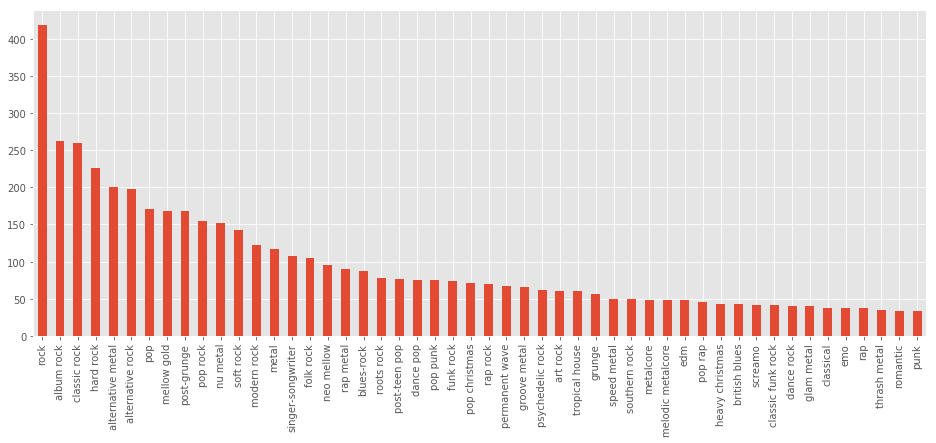

In [32]:
genres_bin.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar", figsize=(16,6));

In [33]:
tf  = genres_bin.sum(axis=0)
idf = np.log(genres_bin.shape[0] / tf)
genres_idf = genres_bin * idf

In [34]:
genres_cooc = genres_bin.T.dot(genres_bin)

In [35]:
genres_cooc

,acoustic pop,adult standards,album rock,alternative emo,alternative hip hop,alternative metal,alternative pop,alternative rock,anthem emo,anti-folk,...,vapor soul,vapor twitch,vegas indie,viking metal,viral pop,visual kei,vocal house,vocal jazz,wrestling,zapstep
acoustic pop,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
adult standards,0,13,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
album rock,0,13,262,0,0,25,0,53,0,0,...,0,0,0,0,0,0,0,0,3,0
alternative emo,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
alternative hip hop,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alternative metal,0,0,25,0,0,201,0,123,0,0,...,0,0,0,2,0,0,0,0,15,0
alternative pop,0,0,0,0,0,0,3,3,0,1,...,0,0,0,0,0,0,0,0,0,0
alternative rock,0,0,53,0,0,123,3,198,0,1,...,0,0,0,0,0,0,0,0,13,0
anthem emo,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
anti-folk,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
from scipy.spatial.distance import dice, pdist, squareform

In [37]:
dists = pdist(genres_idf, 'dice')

In [38]:
sims = pd.DataFrame(1 - squareform(dists))

In [45]:
i = 800
idx = sims[i].sort_values(ascending=False).index

print metadata_aligned.iloc[i]

result = metadata_aligned.iloc[idx]
result["sim"] = sims[i].iloc[idx].values
result = result[["featurespace_index", "artist_name", "title", "year", "popularity", "genres", "sim"]]
result[(result.sim > 0) & (result.index != i)][:10]
#result[(result.sim < 0.00001)]

index                                                837
track_id                          3XR1t5e2teHzxqEsY29D8n
artist_name                                        J HUS
title                 Did You See - French Montana Remix
album_name            Did You See (French Montana Remix)
label                                       Black Butter
duration                                          181293
popularity                                            69
year                                                2017
genres                                    [grime, house]
playlist                                          hiphop
featurespace_index                                   837
Name: 800, dtype: object


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,featurespace_index,artist_name,title,year,popularity,genres,sim
50,62,Black Saint,Never Did This Before,2017,66,"[deep groove house, house]",0.5
25,30,Felon,Trill Witcha,2017,42,"[deep groove house, house]",0.5
41,49,Felon,Dreamer,2017,45,"[deep groove house, house]",0.5
12,17,Ryan Blyth,Show Me (feat. Malisha Bleau),2016,66,"[deep groove house, house]",0.5
49,60,DR. KUCHO!,Love Is My Game,2016,50,"[deep groove house, house]",0.5
23,28,Lee Walker,Freak Like Me (feat. Katy B & MNEK) - Radio Edit,2016,65,"[deep groove house, house]",0.5
230,250,Jax Jones,Instruction (feat. Demi Lovato & Stefflon Don),2017,87,"[house, pop, tropical house]",0.4
13,18,Jax Jones,Instruction (feat. Demi Lovato & Stefflon Don),2017,87,"[house, pop, tropical house]",0.4
14,19,James Hype,More Than Friends (feat. Kelli-Leigh),2017,77,"[deep groove house, house, tropical house]",0.4
236,259,James Hype,More Than Friends (feat. Kelli-Leigh),2017,77,"[deep groove house, house, tropical house]",0.4


In [40]:
def create_pairs_genres(sequential_features, trackbased_features, metadata_aligned, sims, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    
    pairs_index  = []
    pairs_data   = []
    pairs_track_data = []
    labels = []
    
    for i in range(sims.shape[0]):
        
        sim_values = sims[i]
        
        sim_idx    = sim_values.sort_values(ascending=False).index[:21]
        sim_idx    = sim_idx[sim_idx != i][:20]
        dissim_idx = sim_values[sim_values == 0].sample(20).index
        
        similar    = metadata_aligned.iloc[sim_idx].featurespace_index.values
        dissimilar = metadata_aligned.iloc[dissim_idx].featurespace_index.values
        
        pairs_index.append([i,i])
        pairs_data.append([sequential_features[i], sequential_features[i]])
        pairs_track_data.append([trackbased_features[i], trackbased_features[i]])
        labels.append(1.)
        
        for si, di, s,d in zip(sim_idx, dissim_idx, similar, dissimilar):
            
            pairs_index.append([i,s])
            pairs_data.append([sequential_features[i], sequential_features[s]])
            pairs_track_data.append([trackbased_features[i], trackbased_features[s]])
            sim = np.max([0, sims[i].loc[si] - 0.2])
            labels.append(sim)
            
            pairs_index.append([i,d])
            pairs_data.append([sequential_features[i], sequential_features[d]])
            pairs_track_data.append([trackbased_features[i], trackbased_features[d]])
            sim = np.max([0, sims[i].loc[di] - 0.2])
            labels.append(sim)
            
            pairs_index.append([s,i])
            pairs_data.append([sequential_features[s], sequential_features[i]])
            pairs_track_data.append([trackbased_features[s], trackbased_features[i]])
            sim = np.max([0, sims[i].loc[si] - 0.2])
            labels.append(sim)
            
            pairs_index.append([d,i])
            pairs_data.append([sequential_features[d], sequential_features[i]])
            pairs_track_data.append([trackbased_features[d], trackbased_features[i]])
            sim = np.max([0, sims[i].loc[di] - 0.2])
            labels.append(sim)

            
    return np.array(pairs_data), np.array(pairs_track_data), np.array(pairs_index), np.array(labels)

pd_, ptd_, pi_, l_ = create_pairs_genres(sequential_features, trackbased_features, metadata_aligned, sims, 20000)


In [41]:
pd_.shape, l_.shape

((74844, 2, 20, 29), (74844,))

In [42]:
input_dim = pd_[:, 0].shape[1:]

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
input_a2 = Input(shape=(11,))
input_b2 = Input(shape=(11,))

bdlstm = Bidirectional(LSTM(29, return_sequences=False, activation="selu"))

processed_a = bdlstm(input_a)
processed_b = bdlstm(input_b)

dens = Dense(11, activation="selu")

processed_a2 = dens(input_a2)
processed_b2 = dens(input_b2)

left = concatenate([processed_a, processed_a2], axis=1)
right = concatenate([processed_b, processed_b2], axis=1)

merged = concatenate([left, right], axis=1)

prediction = Dense(29 + 11, activation="elu")(merged)
#prediction = Dense(64, activation="elu")(prediction)

prediction = Dense(1, activation="sigmoid")(prediction)

model = Model([input_a, input_b, input_a2, input_b2], prediction)

# train
rms = Nadam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=rms, metrics=["mean_squared_error", "accuracy"])

In [43]:
model.fit([pd_[:, 0], pd_[:, 1], ptd_[:,0], ptd_[:,1]], l_, batch_size=24, verbose=1, epochs=25)

Epoch 1/25
74844/74844 [==============================] - 76s - loss: 0.0663 - mean_squared_error: 0.0663 - acc: 0.5098    
Epoch 2/25
74844/74844 [==============================] - 76s - loss: 0.0406 - mean_squared_error: 0.0406 - acc: 0.5143    
Epoch 3/25
74844/74844 [==============================] - 75s - loss: 0.0334 - mean_squared_error: 0.0334 - acc: 0.5167    
Epoch 4/25
74844/74844 [==============================] - 75s - loss: 0.0303 - mean_squared_error: 0.0303 - acc: 0.5174    
Epoch 5/25
74844/74844 [==============================] - 74s - loss: 0.0281 - mean_squared_error: 0.0281 - acc: 0.5187    
Epoch 6/25
74844/74844 [==============================] - 74s - loss: 0.0267 - mean_squared_error: 0.0267 - acc: 0.5195    
Epoch 7/25
19536/74844 [======>.......................] - ETA: 55s - loss: 0.0249 - mean_squared_error: 0.0249 - acc: 0.5238

KeyboardInterrupt: 